# SVM Classifier for smaller dataset

http://www.developintelligence.com/blog/2017/06/practical-neural-networks-keras-classifying-yelp-reviews/


Conversely, for smaller datasets, the SVM is much better than the neural network.
The SVM, on the other hand, will perform well even for much smaller datasets.

Now, instead of converting each word to a single number and learning an Embedding layer, we use a term-frequency inverse document frequency (TF-IDF) vectorisation process. Using this vectorisation scheme, we ignore the order of the words completely, and represent each review as a large sparse matrix, with each cell representing a specific word, and how often it appears in that review. We normalize the counts by the total number of times the word appears in all of the reviews, so rare words are given a higher importance than common ones (though we ignore all words that aren’t seen in at least three different reviews.

    Line six sets up the vectorizer. We set ngram_range to (1,2) which means we’ll consider all words on their own but also look at all pairs of words. This is useful because we don’t have a concept of word order anymore, so looking at pairs of words as single tokens allows the classifier to learn that word pairs such as “not good” are usually negative, even though “good” is positive. We also set min_df to 3, which means that we’ll ignore words that aren’t seen at least three times (in three different reviews).

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"

from collections import Counter
from datetime import datetime
import numpy as np
import time
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import pathlib
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
import json

from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
import numpy as np

from sklearn.model_selection import StratifiedKFold

%matplotlib inline 



/home/elkhand/anaconda3/envs/cs231n/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
captions_root = "/home/elkhand/git-repos/human-emotions-classifier/dataset/metadata"
captions_root_path = pathlib.Path(captions_root)
human_output_caption_to_label_csv_path = captions_root_path/'humanCaptionWithLabeldf.csv'
dataset_path = human_output_caption_to_label_csv_path

stop_words = set(stopwords.words('english'))

def get_words_withoutstopwords(words):
    words_without_stopwords = []
    for word in words:
        if word not in stop_words:
            words_without_stopwords.append(word)
    return words_without_stopwords

def change_label_str_to_int(labelStr,isBinaryClassification):
    """this is only for binary classification, negative sentiment has value 0, positive sentiment has value 1"""
    if labelStr == "negative":
        if isBinaryClassification:
            return 0
        else:
            return -1
    elif  labelStr == "neutral":
        if isBinaryClassification:
            raise "Neutral Should not exist"
        else:
            return 0
    elif  labelStr == "positive":
        return 1
    else:
        raise labelStr+ " Should not exist"
      
        
def get_df(isBinaryClassification):
    df = pd.read_csv(dataset_path, header=0, sep="|")
    if isBinaryClassification:
        # Doing only binary classification
        df = df[(df.label == "negative") | (df.label == "positive")]
        df = df.reset_index()
    df["label"] = df["label"].apply(lambda x: change_label_str_to_int(x, isBinaryClassification))
    df["caption"] = df["caption"].apply(lambda x: " ".join(get_words_withoutstopwords(x.lower().split())))
    return df    
        

isBinaryClassification = False    
    
df = get_df(isBinaryClassification)
print("Classes: ", df.label.nunique())
balanced_texts = []
balanced_labels = []

for index, row in df.iterrows():
    label = int(row['label'])
    caption = row['caption']
    balanced_texts.append(caption)
    balanced_labels.append(label)

        
print(Counter(balanced_labels))


vectorizer = TfidfVectorizer(ngram_range=(1,4), min_df=0)
classifier = LinearSVC()
Xs = vectorizer.fit_transform(balanced_texts)
print("Vectors shape:", Xs.shape)

kFoldSplits = 10

scores = cross_val_score(classifier, Xs, balanced_labels, cv=kFoldSplits, n_jobs=-1)

print("Cross-Validation scores: ",scores)
print("Cross-validation results: %.2f%% (+/- %.2f%%)" % (np.mean(scores), np.std(scores)))




Classes:  3
Counter({0: 420, 1: 317, -1: 163})
Vectors shape: (900, 21279)
Cross-Validation scores:  [0.52747253 0.3956044  0.6043956  0.41111111 0.56666667 0.41111111
 0.53333333 0.52808989 0.59550562 0.56179775]
Cross-validation results: 0.51% (+/- 0.07%)


# New Neural Network based on Tf-IDF

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 40, 32)            320000    
_________________________________________________________________
dropout_33 (Dropout)         (None, 40, 32)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 38, 32)            3104      
_________________________________________________________________
dropout_34 (Dropout)         (None, 38, 32)            0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 19, 32)            0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 19, 32)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                8320      
__________

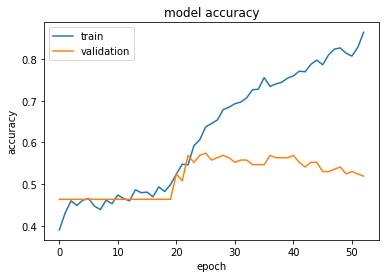

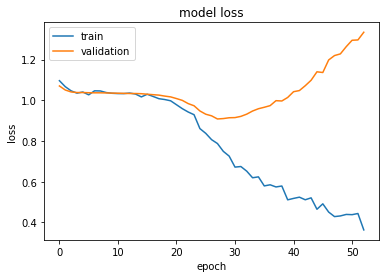

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 40, 32)            320000    
_________________________________________________________________
dropout_37 (Dropout)         (None, 40, 32)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 38, 32)            3104      
_________________________________________________________________
dropout_38 (Dropout)         (None, 38, 32)            0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 19, 32)            0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 19, 32)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                8320      
__________

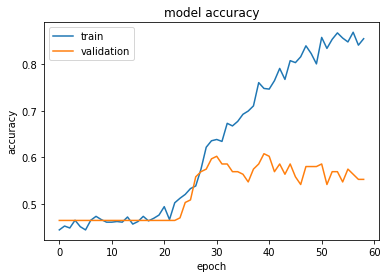

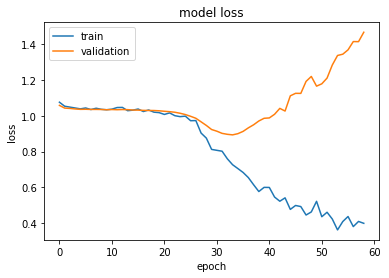

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 40, 32)            320000    
_________________________________________________________________
dropout_41 (Dropout)         (None, 40, 32)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 38, 32)            3104      
_________________________________________________________________
dropout_42 (Dropout)         (None, 38, 32)            0         
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 19, 32)            0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 19, 32)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                8320      
__________

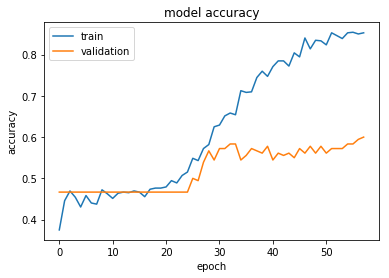

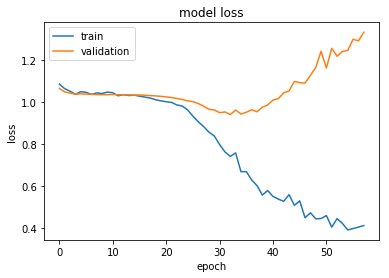

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 40, 32)            320000    
_________________________________________________________________
dropout_45 (Dropout)         (None, 40, 32)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 38, 32)            3104      
_________________________________________________________________
dropout_46 (Dropout)         (None, 38, 32)            0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 19, 32)            0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 19, 32)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                8320      
__________

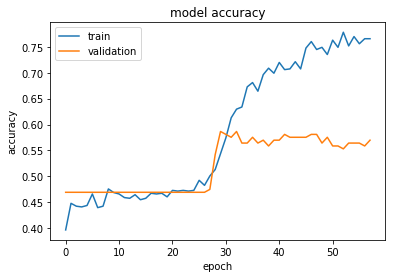

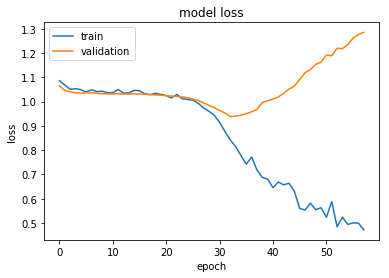

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 40, 32)            320000    
_________________________________________________________________
dropout_49 (Dropout)         (None, 40, 32)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 38, 32)            3104      
_________________________________________________________________
dropout_50 (Dropout)         (None, 38, 32)            0         
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 19, 32)            0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 19, 32)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                8320      
__________

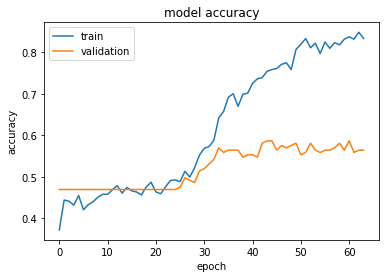

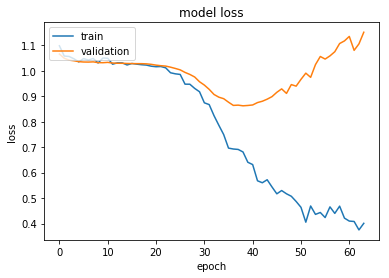

Cross-validation results: 0.59% (+/- 0.01%)


In [13]:
##############################################################
# New Neural Network with Embedding layer

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
num_words = 10000
maxlen = 40


config = tf.ConfigProto()
config.gpu_options.allow_growth = True

def generate_model_name(filename, best_acc_val):
    timestamp = str(time.time()).split(".")[0]
    best_acc_val = round(best_acc_val,4)
    filename += "-" + str(best_acc_val) + "-" + timestamp
    return filename

def plot_model_accuracy(history):
    """plot acc and loss for train and val"""
    filename = "custom-hec" 
    filename = generate_model_name(filename + "-acc", max(history.history['val_acc']))
    fig = plt.figure()
    print(history.history.keys())
    print("best_val_acc", max(history.history['val_acc']))
    print("best_train_acc", max(history.history['acc']))
    print("lowest_val_loss", min(history.history['val_loss']))
    print("lowest_train_loss", min(history.history['loss']))
    #  "Accuracy"
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    fig.savefig("custom-model/" + filename + ".png") 
    
    # "Loss"
    fig = plt.figure()
    filename = "hec" 
    filename = generate_model_name(filename + "-loss", min(history.history['val_loss']))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    fig.savefig("custom-model/" + filename + ".png") 

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(balanced_texts)
sequences = tokenizer.texts_to_sequences(balanced_texts)
data = pad_sequences(sequences, maxlen=maxlen)

#This might take a while to run. Here, we use the most common 20000 words instead of 5. 
#The only other difference is that we pass maxlen=300 when we pad the sequences. 
#This means that as well as padding the very short texts with zeros,
#we’ll also truncate the very long ones. All of our texts will then be represented by 300 numbers.


filepath="custom-model/customNN.weights.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=25)
callbacks_list = [ checkpoint, early_stopping] # reduce_lr,

#In line two, we add an Embedding layer. This layer lets the network expand each token to a larger vector, 
#allowing the network to represent words in a meaningful way. We pass 20000 as the first argument, 
#which is the size of our vocabulary (remember, we told the tokenizer to only use the 20 000 most common words 
#earlier), and 128 as the second, which means that each token can be expanded to a vector of size 128. 
#We give it an input_length of 300, which is the length of each of our sequences.


def load_dataset_StratifiedKFold(dfKFold, max_seq_len):
    sentences = []
    label_index = []
    num_of_classes = 0
    class_to_index = {}
    index_to_class = {}
    for index, row in dfKFold.iterrows():
        caption = row['caption']
        label = row['label']
        sentence = caption
        words = sentence.split(" ")
        words = get_non_stop_words(words)
        sentence_embedding = get_sequence_embedding(words, max_seq_len)
        sentences.append(sentence_embedding)
        if label in class_to_index:
            label_index.append(class_to_index[label])
        else:
            num_of_classes += 1
            class_to_index[label] = num_of_classes - 1
            index_to_class[num_of_classes - 1] = label
            label_index.append(class_to_index[label])
    X_train = np.array(sentences)
    y_train = np.array(label_index)
    return (X_train, y_train, num_of_classes)



def get_LSTM_model(dropout, recurrent_dropout, isBinaryClassification):
    # Cross-validation results: 0.84% (+/- 0.06%)
    model = Sequential()
    model.add(Embedding(num_words, 32, input_length=maxlen))
    model.add(Dropout(dropout))
    model.add(LSTM(32, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dropout(dropout))
    if isBinaryClassification:
        activation = 'sigmoid'
        loss='binary_crossentropy'
        model.add(Dense(1, activation=activation))
    else:
        activation = 'softmax'
        #loss='categorical_crossentropy'
        loss = 'sparse_categorical_crossentropy'
        num_classes = 3
        model.add(Dense(num_classes, activation=activation))
        #model.add(Activation("softmax"))

    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model


def get_CNN_model(dropout, recurrent_dropout, isBinaryClassification):
    # Cross-validation results: 0.80% (+/- 0.03%), with dropout = 0.2
    # Cross-validation results: 0.83% (+/- 0.05%)
    model = Sequential()
    model.add(Embedding(num_words, 32, input_length=maxlen))# 128
    model.add(Dropout(dropout))
    model.add(Conv1D(32, 3, activation='relu'))# 64, 5
    model.add(Dropout(dropout))
    model.add(MaxPooling1D(pool_size=2)) #4
    model.add(Dropout(dropout)) # 0.2
    model.add(LSTM(32, dropout=dropout, recurrent_dropout=recurrent_dropout)) # 128
    model.add(Dropout(dropout))
    
    if isBinaryClassification:
        activation = 'sigmoid'
        loss='binary_crossentropy'
        model.add(Dense(1, activation=activation))
    else:
        activation = 'softmax'
        #loss='categorical_crossentropy'
        loss = 'sparse_categorical_crossentropy'
        num_classes = 3
        model.add(Dense(num_classes, activation=activation))
        #model.add(Activation("softmax"))
    
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model


def get_label_count(labels):
    labelToCount = {}
    for label in labels:
        if label not in labelToCount:
            labelToCount[label] = 1
        else:
            labelToCount[label] += 1
    return labelToCount



labelencoder_y_1 = LabelEncoder()

# Instantiate the cross validator
kfold_splits = 5
skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
printCnt = 5
cvscores = []
isBinaryClassification = False
balanced_labels = np.array(balanced_labels)
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(data, balanced_labels)):
    X_train, X_val = data[train_indices], data[val_indices]
    y_train, y_val = balanced_labels[train_indices], balanced_labels[val_indices]
    
    
    #print("y_val",y_val)
    y_train = labelencoder_y_1.fit_transform(y_train)
    y_val = labelencoder_y_1.fit_transform(y_val)
    
    #print("y_val",y_val)
    
    #y_train = to_categorical(y_train)
    #y_val = to_categorical(y_val)
    
    
    dropout = 0.65
    recurrent_dropout = 0.65
    model = get_CNN_model(dropout, recurrent_dropout, isBinaryClassification)
    #model = get_LSTM_model(dropout, recurrent_dropout, isBinaryClassification)
    #history = model.fit(data, np.array(balanced_labels), validation_split=0.2, epochs=100, callbacks=callbacks_list)
    history = model.fit(x=X_train,
                          y=y_train, 
                          batch_size=16,# 64 seems fine, 32 is better 
                          epochs=100, 
                          verbose=0, 
                          validation_data = (X_val, y_val),
                          shuffle=True,
                          callbacks=callbacks_list) 


    val_acc_list = history.history['val_acc']
    best_val_acc =  max(val_acc_list)
    cvscores.append(best_val_acc)
    print("best_val_acc: ", best_val_acc)
    plot_model_accuracy(history)
    
print("Cross-validation results: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))    